In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All rights reserved.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/myAMMI/3D

Mounted at /content/drive
/content/drive/MyDrive/myAMMI/3D


# Deform a source mesh to form a target mesh using 3D loss functions

In this tutorial, we learn to deform an initial generic shape (e.g. sphere) to fit a target shape.

We will cover: 

- How to **load a mesh** from an `.obj` file
- How to use the PyTorch3D **Meshes** datastructure
- How to use 4 different PyTorch3D **mesh loss functions**
- How to set up an **optimization loop**


Starting from a sphere mesh, we learn the offset to each vertex in the mesh such that
the predicted mesh is closer to the target mesh at each optimization step. To achieve this we minimize:

+ `chamfer_distance`, the distance between the predicted (deformed) and target mesh, defined as the chamfer distance between the set of pointclouds resulting from **differentiably sampling points** from their surfaces. 

However, solely minimizing the chamfer distance between the predicted and the target mesh will lead to a non-smooth shape (verify this by setting  `w_chamfer=1.0` and all other weights to `0.0`). 

We enforce smoothness by adding **shape regularizers** to the objective. Namely, we add:

+ `mesh_edge_length`, which minimizes the length of the edges in the predicted mesh.
+ `mesh_normal_consistency`, which enforces consistency across the normals of neighboring faces.
+ `mesh_laplacian_smoothing`, which is the laplacian regularizer.

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [ ]:
import os
import sys
import torch

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
    
if need_pytorch3d:
    if torch.__version__.startswith("1.7") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{torch.__version__[0:5:2]}"
        ])
        !pip install pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    802      0 --:--:-- --:--:-- --:--:--   802
100  404k    0  404k    0     0   824k      0 --:--:-- --:--:-- --:--:--  824k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-2kmhku3q
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-2kmhku3q
  Running command git checkout -q 3c15a6c2469249c8b90a4f3e41e34350b8051b92
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 645kB 30.7MB/s 


In [ ]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

In [ ]:
def save_mesh(exp_name, i, mesh):
    # Fetch the verts and faces of the final predicted mesh
    final_verts, final_faces = mesh.get_mesh_verts_faces(0)

    # Scale normalize back to the original target size
    final_verts = final_verts * scale + center

    # Store the predicted mesh using save_obj
    final_obj = os.path.join(f'./Lab1/{exp_name}/', f'iter_{i}.obj')
    save_obj(final_obj, final_verts, final_faces)

## 1. Load an obj file and create a Meshes object

Download the target 3D model of a dolphin. It will be saved locally as a file called `dolphin.obj`.

In [ ]:
# !wget https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj

In [ ]:
# Load the dolphin mesh.
file_name = 'dolphin'
trg_obj = os.path.join(f'obj/{file_name}.obj')

In [ ]:
# We read the target 3D model using load_obj
verts, faces, aux = load_obj(trg_obj)

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: [verts_idx], normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device) # len = 5120
verts = verts.to(device) # len = 2562

# We scale normalize and center the target mesh to fit in a sphere of radius 1 centered at (0,0,0). 
# (scale, center) will be used to bring the predicted mesh to its original center and scale
# Note that normalizing the target mesh, speeds up the optimization but is not necessary!
center = verts.mean(0) # => verts.mean(dim=0)
verts = verts - center
scale = max(verts.abs().max(0)[0]) # => abs => max(v0,v1,v2)(vals, inx) => max(v0,v1,v2)(vals)
verts = verts / scale

# We construct a Meshes structure for the target mesh
trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

In [ ]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(level=4, device=device) # The larger the level the more vert's & fac's the sph' has

###  Visualize the source and target meshes

In [ ]:
# def plot_pointcloud(mesh, title=""):
#     # Sample points uniformly from the surface of the mesh.
#     points = sample_points_from_meshes(mesh, 5000)
#     x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
#     fig = plt.figure(figsize=(5, 5), dpi=100)
#     ax = Axes3D(fig, auto_add_to_figure=False)
#     fig.add_axes(ax)
#     ax.scatter3D(x, z, -y)
#     ax.set_xlabel('x')
#     ax.set_ylabel('z')
#     ax.set_zlabel('y')
#     ax.set_title(title)
#     ax.view_init(190, 30)
#     plt.show()

In [ ]:
def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [ ]:
# %matplotlib notebook
plot_pointcloud(trg_mesh, "Target mesh")
plot_pointcloud(src_mesh, "Source mesh")

## 3. Optimization loop 

In [27]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(size=src_mesh.verts_packed().shape,
                          fill_value=0.0,
                          device=device,
                          requires_grad=True)
len(deform_verts)

2562

In [28]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [29]:
# Number of optimization steps
nIter = 2000

# Hyperparameters:
#   Weight for the chamfer loss
w_chamfer = 1.0 
#   Weight for mesh edge loss
w_edge = 1.0 
#   Weight for mesh normal consistency
w_normal = 0.01 
#   Weight for mesh laplacian smoothing
w_laplacian = 0.1 


# Plot period for the losses
plot_period = 250

chamfer_losses = []
edge_losses = []
normal_losses = []
laplacian_losses = []

%matplotlib inline

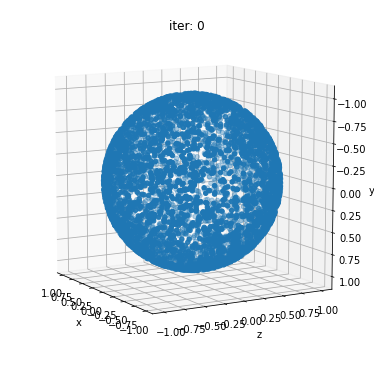

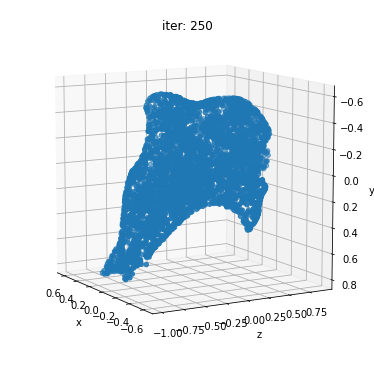

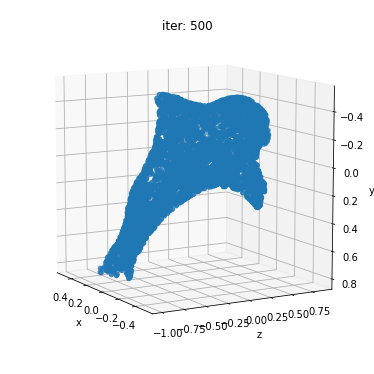

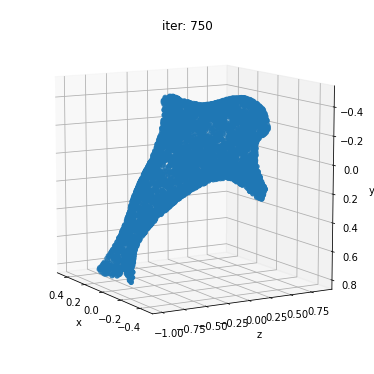

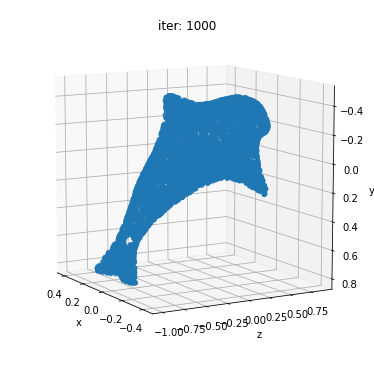

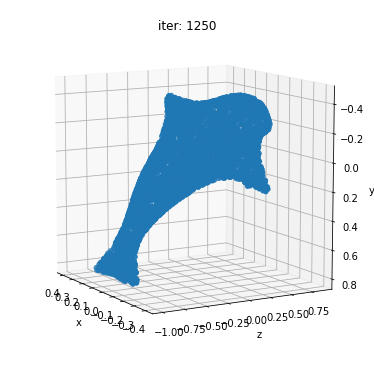

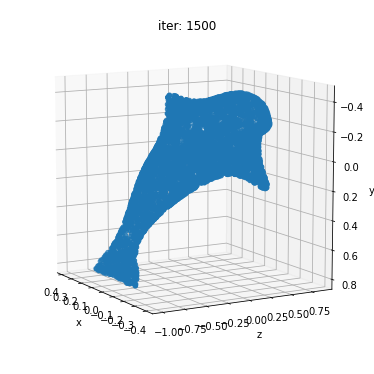

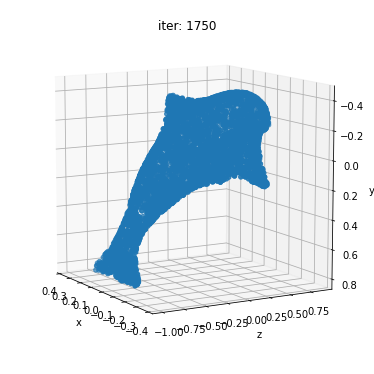

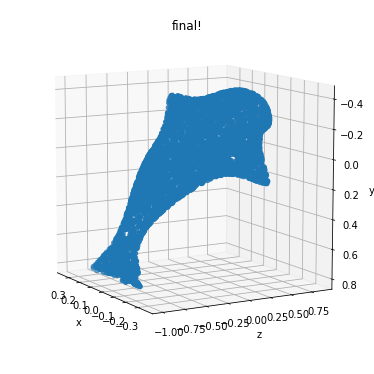

In [30]:
exp_name = 'Base'


loop = tqdm(range(nIter))
for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer\
         + loss_edge * w_edge\
         + loss_normal * w_normal\
         + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        save_mesh(exp_name, i, new_src_mesh)
    elif i == nIter - 1:
        plot_pointcloud(new_src_mesh, title="final!")
        save_mesh(exp_name, 'final', new_src_mesh)
        
    # Optimization step
    loss.backward()
    optimizer.step()

save_mesh(exp_name, 'target', trg_mesh)

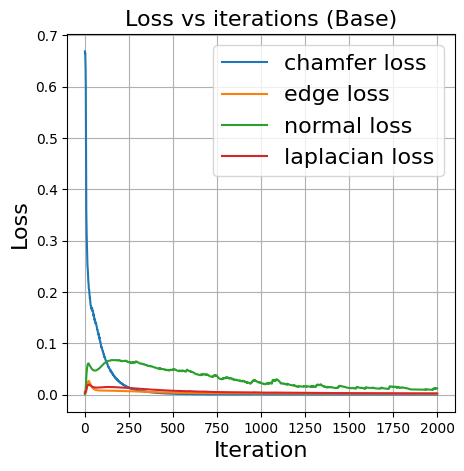

In [31]:
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.grid()
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations (Base)", fontsize="16");

A.2 Zero Losses

In [32]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(size=src_mesh.verts_packed().shape,
                          fill_value=0.0,
                          device=device,
                          requires_grad=True)
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [33]:
# Number of optimization steps
nIter = 2000

# Hyperparameters [A.2]:
#   Weight for the chamfer loss
w_chamfer = 1.0 
#   Weight for mesh edge loss
w_edge = 0
#   Weight for mesh normal consistency
w_normal = 0
#   Weight for mesh laplacian smoothing
w_laplacian = 0


# Plot period for the losses
plot_period = 250

chamfer_losses = []
edge_losses = []
normal_losses = []
laplacian_losses = []

%matplotlib inline

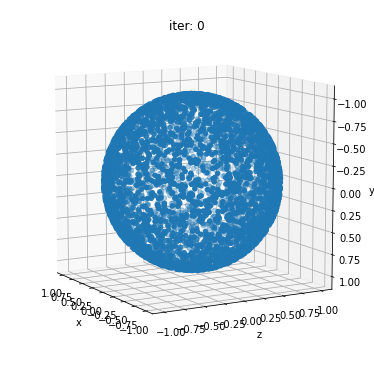

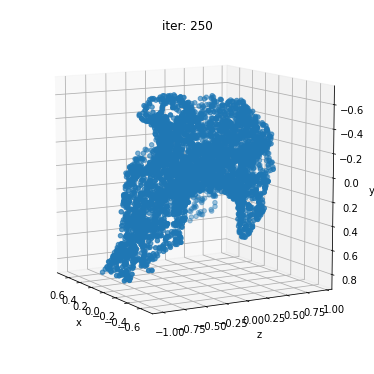

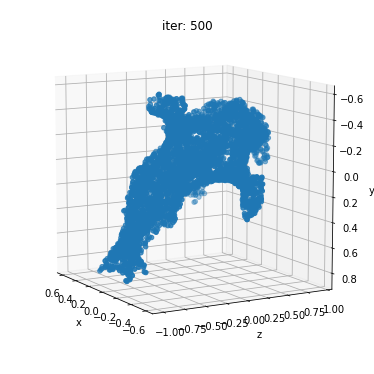

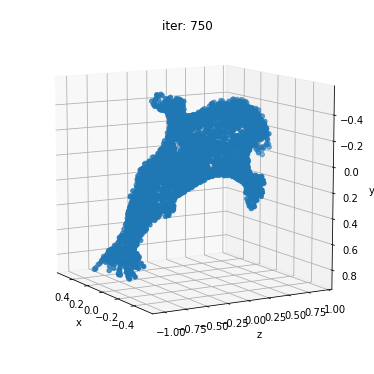

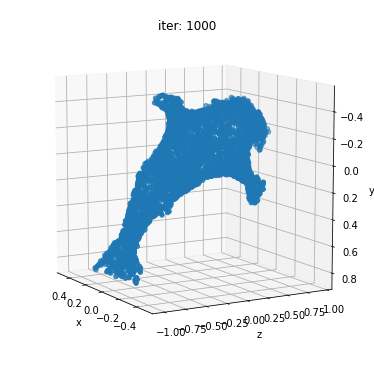

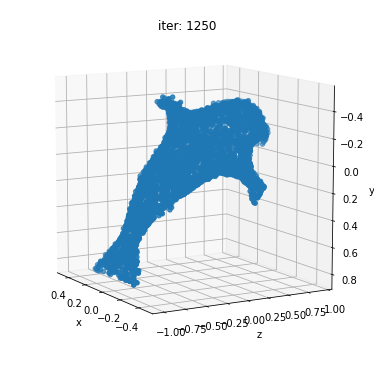

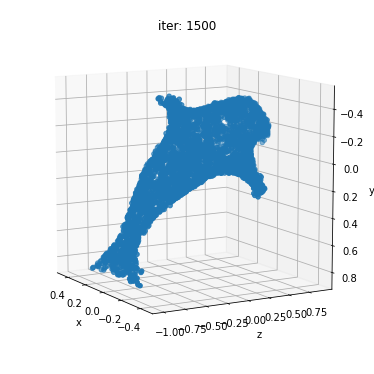

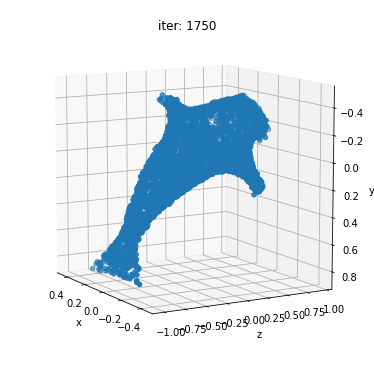

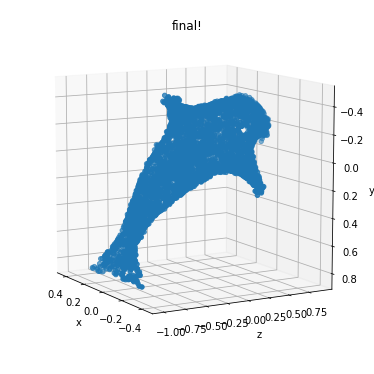

In [34]:
exp_name = 'ZeroWs'


loop = tqdm(range(nIter))
for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer\
         + loss_edge * w_edge\
         + loss_normal * w_normal\
         + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        save_mesh(exp_name, i, new_src_mesh)
    elif i == nIter - 1:
        plot_pointcloud(new_src_mesh, title="final!")
        save_mesh(exp_name, 'final', new_src_mesh)
        
    # Optimization step
    loss.backward()
    optimizer.step()

save_mesh(exp_name, 'target', trg_mesh)

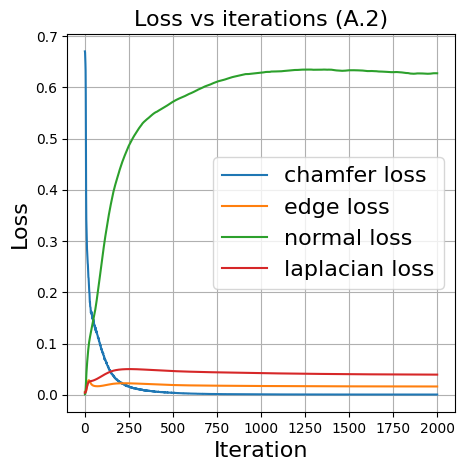

In [35]:
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.grid()
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations (A.2)", fontsize="16");

A.3 Chaamfer w = 100

In [16]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(size=src_mesh.verts_packed().shape,
                          fill_value=0.0,
                          device=device,
                          requires_grad=True)
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [17]:
# Number of optimization steps
nIter = 2000

# Hyperparameters [A.3]:
#   Weight for the chamfer loss
w_chamfer = 1.0
#   Weight for mesh edge loss
w_edge = 100
#   Weight for mesh normal consistency
w_normal = 0.01 
#   Weight for mesh laplacian smoothing
w_laplacian = 0.1 


# Plot period for the losses
plot_period = 250

chamfer_losses = []
edge_losses = []
normal_losses = []
laplacian_losses = []

%matplotlib inline

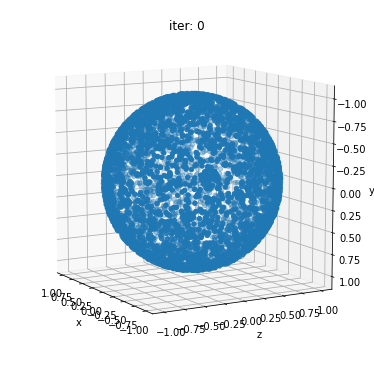

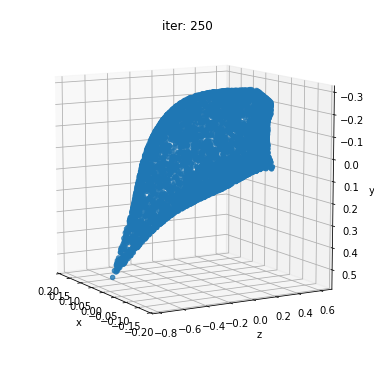

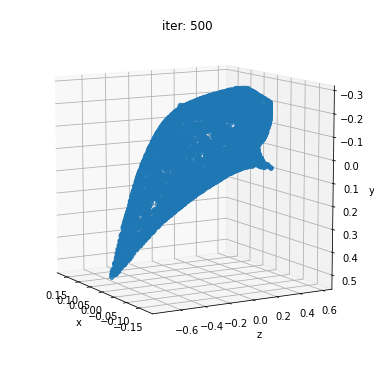

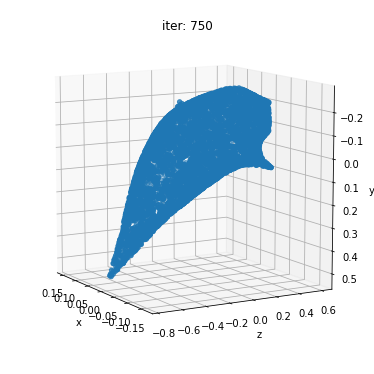

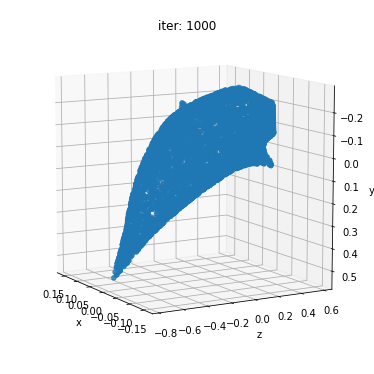

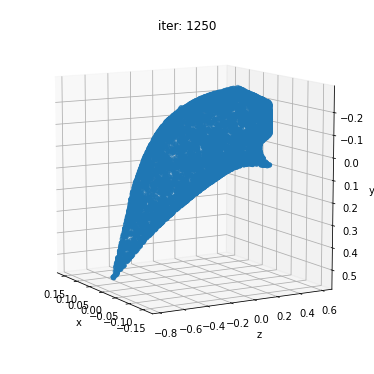

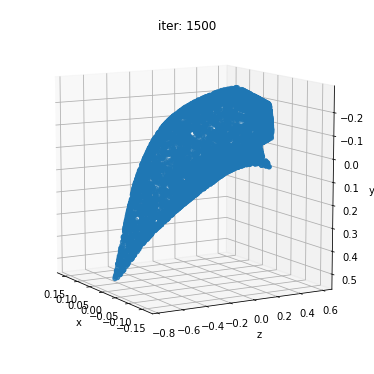

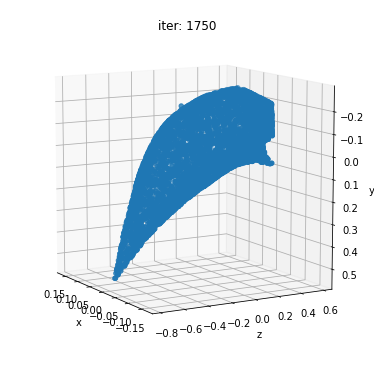

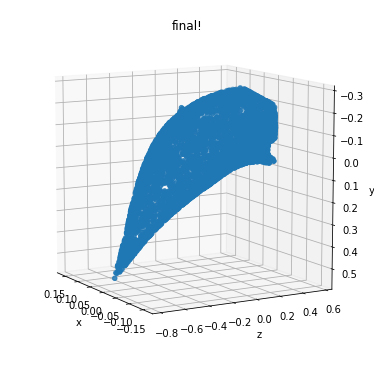

In [18]:
exp_name = 'edgeW'


loop = tqdm(range(nIter))
for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer\
         + loss_edge * w_edge\
         + loss_normal * w_normal\
         + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        save_mesh(exp_name, i, new_src_mesh)
    elif i == nIter - 1:
        plot_pointcloud(new_src_mesh, title="final!")
        save_mesh(exp_name, 'final', new_src_mesh)
        
    # Optimization step
    loss.backward()
    optimizer.step()

save_mesh(exp_name, 'target', trg_mesh)

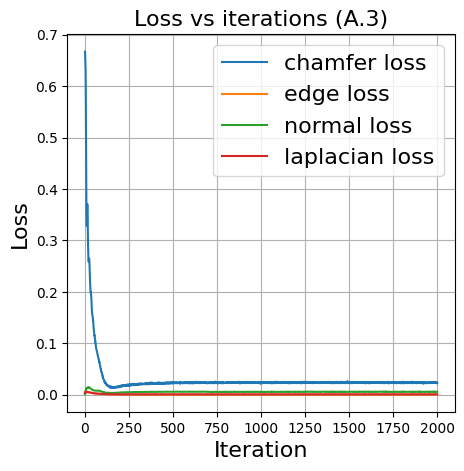

In [19]:
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.grid()
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations (A.3)", fontsize="16");

B.2 Sphere Level = 1

In [21]:
# We initialize the source shape to be a sphere of radius 1
src_mesh = ico_sphere(level=1, device=device) # The larger the level the more vert's & fac's the sph' has

In [23]:
# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in src_mesh
deform_verts = torch.full(size=src_mesh.verts_packed().shape,
                          fill_value=0.0,
                          device=device,
                          requires_grad=True)
len(deform_verts)

42

In [24]:
# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

In [25]:
# Number of optimization steps
nIter = 2000

# Hyperparameters:
#   Weight for the chamfer loss
w_chamfer = 1.0 
#   Weight for mesh edge loss
w_edge = 1.0 
#   Weight for mesh normal consistency
w_normal = 0.01 
#   Weight for mesh laplacian smoothing
w_laplacian = 0.1 


# Plot period for the losses
plot_period = 250

chamfer_losses = []
edge_losses = []
normal_losses = []
laplacian_losses = []

%matplotlib inline

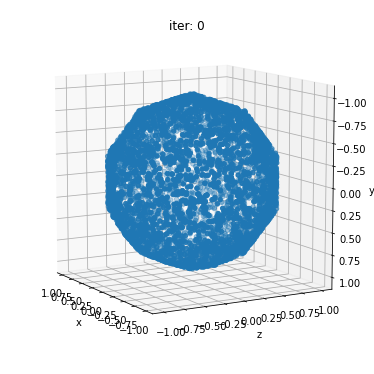

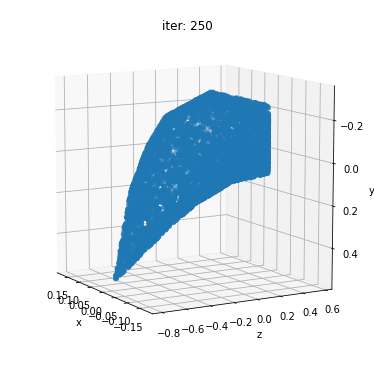

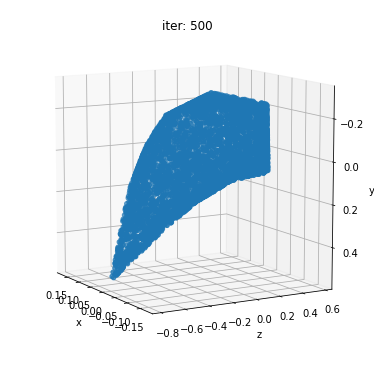

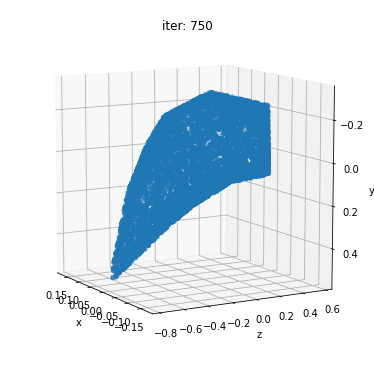

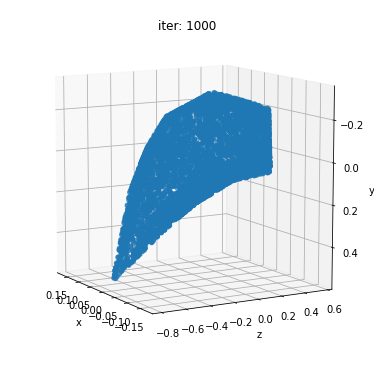

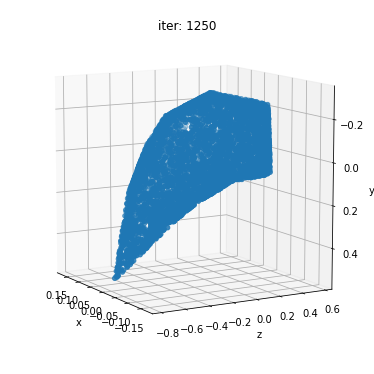

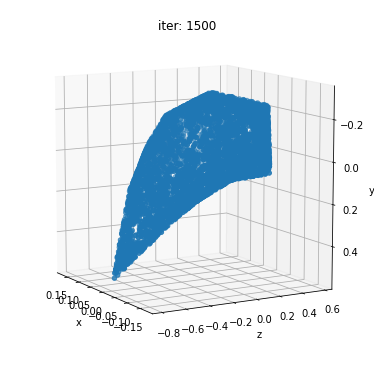

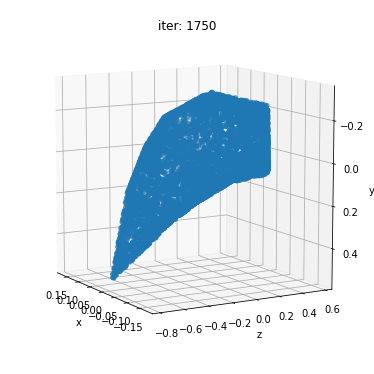

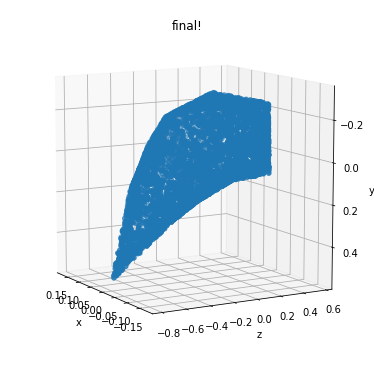

In [26]:
exp_name = 'SphereLevel1'


loop = tqdm(range(nIter))
for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(trg_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer\
         + loss_edge * w_edge\
         + loss_normal * w_normal\
         + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    
    # Plot mesh
    if i % plot_period == 0:
        plot_pointcloud(new_src_mesh, title="iter: %d" % i)
        save_mesh(exp_name, i, new_src_mesh)
    elif i == nIter - 1:
        plot_pointcloud(new_src_mesh, title="final!")
        save_mesh(exp_name, 'final', new_src_mesh)
        
    # Optimization step
    loss.backward()
    optimizer.step()

save_mesh(exp_name, 'target', trg_mesh)

In [ ]:
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.grid()
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations (B.2)", fontsize="16");

## 4. Visualize the loss

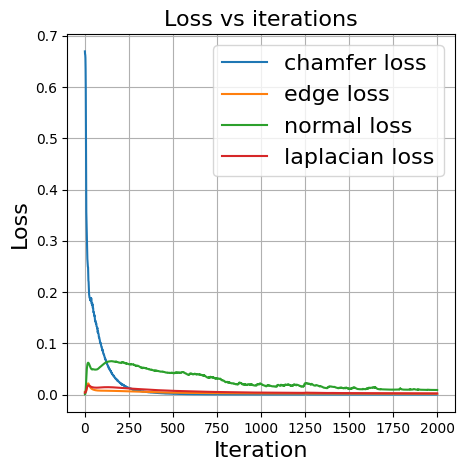

In [ ]:
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.grid()
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16");

## 5. Save the predicted mesh

In [ ]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./Lab1/', f'iter_{i}.obj')
save_obj(final_obj, final_verts, final_faces)

In [ ]:
def save_mesh(exp_name, i, mesh):
    # Fetch the verts and faces of the final predicted mesh
    final_verts, final_faces = mesh.get_mesh_verts_faces(0)

    # Scale normalize back to the original target size
    final_verts = final_verts * scale + center

    # Store the predicted mesh using save_obj
    final_obj = os.path.join(f'./Lab1/{exp_name}/', f'iter_{i}.obj')
    save_obj(final_obj, final_verts, final_faces)

## 6. Conclusion 

In this tutorial we learnt how to load a mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an optimization loop and use four different PyTorch3D mesh loss functions. 